In [341]:
import pandas as pd
import matplotlib.pyplot as plt
import ppscore as pps
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import numpy as np
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report,
    accuracy_score,
)

# Employee turnover: Predecir la probabilidad de que un empleado renuncie usando Machine Learning
### ¿Cómo podemos retener nuestro talento?

Es una pregunta que toda organización del mundo debería hacerse.
El talento es el insumo de mayor valor para cada organización,
dado que es el mayor generador de valor:
No importan los recursos si no hay gente habilidosa, motivada detrás de ellos.

Para poder retener el talento, es necesario entender
la razón de la salida de los empleados: si se sabe quién está en riesgo
 de abandonar la organización, se pueden tomar medidas preventivas.

En el presente Jupyter notebook, se ilustrará el proceso
para la obtención de un modelo preliminar de
Machine Learning para la predicción de la probabilidad de que
un empleado abandone una organización. Para esto,
se utilizará un dataset de Kaggle que contiene una serie
 de features asociadas a los empleados, además de
 una variable binaria que determina si el empleado abandonó o no la organización.

A grandes rasgos, los pasos que se seguirán serán:

* **Carga y validación de los datos**:
 Se verifica que los datos a usar sean integrales, que no haya faltantes, que sus valores sean coherentes con la realidad.
* **Análisis Exploratorio**:
Se exploran los datos para detectar posibles interacciones de interés. En el caso de dataset con muchos features, se usaría como base para empezar con los modelos.
* **Preparación de los datos**:
 Se realiza preparación y limpieza de datos para los modelos (Normalizar, Estandarizar, Upsampling/Downsampling, generación de datos sintéticos, rellenado de faltantes, entre otras posibilidades). Adicionalmente, se separa un fragmento de los datos para posteriormente probar los modelos en ellos.
* **Modelado inicial**:
Se prueba con algunos modelos básicos.
* **Optimización de hiper parámetros**:
Se aproxima a la mejor combinación de hiper parámetros del modelo seleccionado para los datos que se tienen.
* **Selección del mejor modelo**:
 Con los datos separados en el punto 3, se prueban todos los modelos y se elige aquel con un mejor desempeño.


## Carga y exploración básica

Los features del dataset son:

- **satisfaction_level**: Nivel de Satisfacción, de 0 a 1 (Flotante).
- **last_evaluation**: Años desde la última evaluación de desempeño (Flotante)
- **number_project**: Cantidad de proyectos terminados durante la vinculación laboral (Entera)
- **average_montly_hours**: Horas promedio mensuales trabajadas (Entera)
- **time_spend_company**: Años de vinculación en la compañía (Entera)
- **Work_accident**: Si el empleado tuvo o no Accidente de trabajo (Binaria)
- **left**: Si el empleado dejo o no el trabajo (Variable Respuesta) (Binaria)
- **promotion_last_5years**: Si el empleado tuvo o no un ascenso en los últimos 5 años (Binaria).
- **sales**: Departamento al que el empleado estuvo vinculado (Categórica).
- **salary**: Nivel relativo del salario (low, medium, high) (Categórica)

Se cargan los datos y se validan ciertos elementos, a saber:

* Que no haya datos faltantes
* Que todos los datos sean coherentes con las variables
* Que la variable respuesta esté balanceada

Después de estas validaciones iniciales, se modifican los nombres de las variables
para su interpretabilidad y se realiza un Análisis de Datos Exploratorio para conocer
mejor el dataset.

In [343]:
df = pd.read_csv("datos.csv")
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [168]:
# Verificación de datos nulos en el dataset
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [348]:
# Para variables categoricas y binarias, verificación de que no hayan elementos mal escritos o similar.
# Para esto, se imprimen los valores únicos de cada variable
variables_bin_cat = [
    "Work_accident",
    "left",
    "promotion_last_5years",
    "sales",
    "salary",
]
[(i, df[i].unique(), len(df[i].unique())) for i in variables_bin_cat]

[('Work_accident', array([0, 1], dtype=int64), 2),
 ('left', array([1, 0], dtype=int64), 2),
 ('promotion_last_5years', array([0, 1], dtype=int64), 2),
 ('sales',
  array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
         'IT', 'product_mng', 'marketing', 'RandD'], dtype=object),
  10),
 ('salary', array(['low', 'medium', 'high'], dtype=object), 3)]

In [357]:
pd.get_dummies(df['sales'])

,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
14994,0,0,0,0,0,0,0,0,1,0
14995,0,0,0,0,0,0,0,0,1,0
14996,0,0,0,0,0,0,0,0,1,0
14997,0,0,0,0,0,0,0,0,1,0


In [350]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [365]:
from sklearn.ensemble import RandomForestClassifier

In [367]:
x = pd.get_dummies(df.drop('salary', axis=1))
y = df['salary']

In [368]:
modelo = RandomForestClassifier()
modelo.fit(x,y)

RandomForestClassifier()

In [369]:
modelo.predict(x)

array(['low', 'medium', 'medium', ..., 'low', 'low', 'low'], dtype=object)

In [371]:
sum(modelo.predict(x) == y)/len(y)

0.9991999466631108

In [170]:
# Para la verificación de variables númericas continuas, se usa DataFrame.describe() para validar el rango de los datos
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [179]:
# Se renombra "sales" como "department", "salary" como "salary_level", "left" como "employee_left"
# Esto es para dar nombres más interpretables de las variables
df = df.rename(
    columns={"sales": "department", "salary": "salary_level", "left": "employee_left",
            "average_montly_hours": "average_monthly_hours"}
)
# Se convierten las variables a tipo Categoría para facilitar el uso de modelos
df = df.astype({"department": "category", "salary_level": "category"})
df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_monthly_hours       int64
time_spend_company          int64
Work_accident               int64
employee_left               int64
promotion_last_5years       int64
department               category
salary_level             category
dtype: object

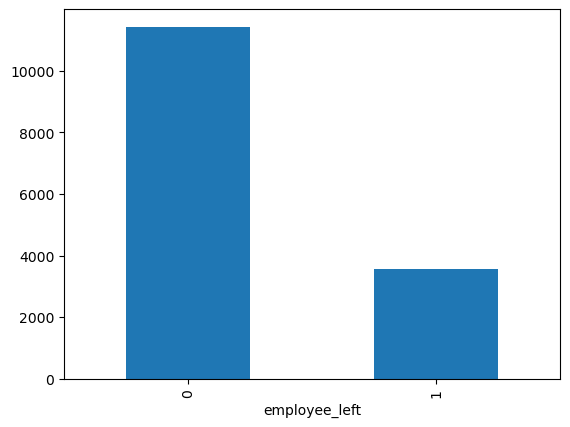

In [180]:
# Se verifica si la variable respuesta se encuentra balanceada en el dataset, mostrando el conteo de la misma
df.groupby("employee_left")["department"].count().plot(kind="bar")
plt.show()

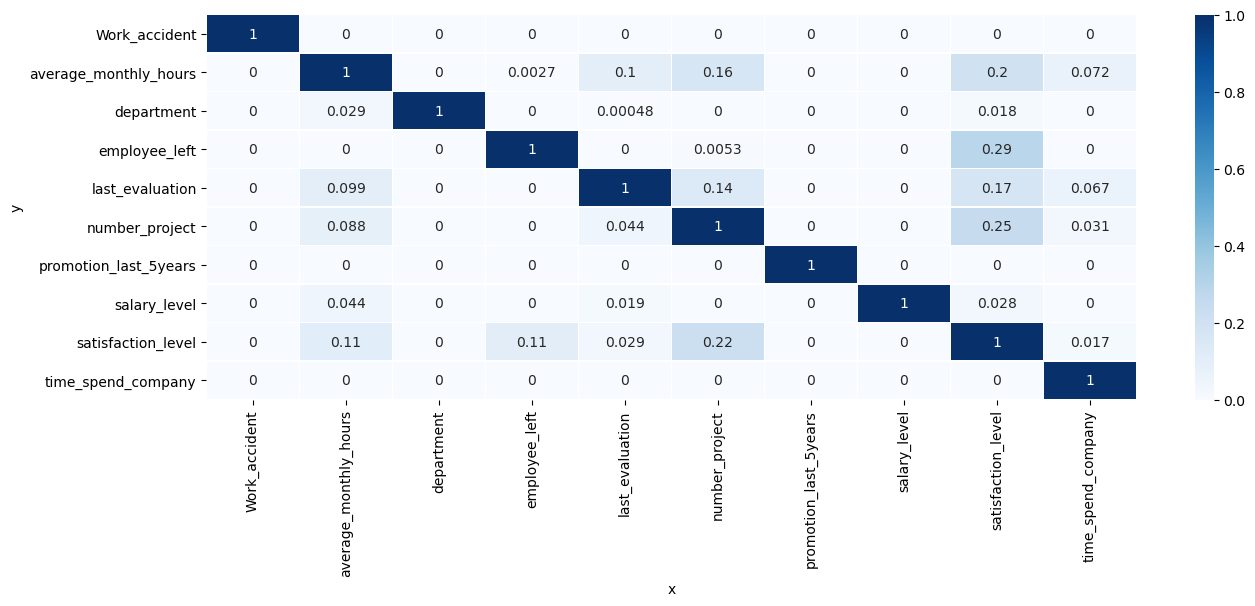

In [181]:
# Se realiza un mapa de calor de Predictive Power Score (PPS).
# El PPS es una métrica que mide el poder predictivo de una variable sobre otra.
# Esta se utiliza para observar correlaciones y posibles variables de interés para los modelos
matrix_df = pps.matrix(df)[["x", "y", "ppscore"]].pivot(
    columns="x", index="y", values="ppscore"
)
plt.figure(figsize=(15, 5))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()

In [378]:
matrix_df

x,Work_accident,average_monthly_hours,department,employee_left,last_evaluation,number_project,promotion_last_5years,salary_level,satisfaction_level,time_spend_company
y,,,,,,,,,,
Work_accident,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
average_monthly_hours,0.0,1.000000,0.0,0.002689,0.100215,0.162129,0.0,0.0,0.195412,0.072289
department,0.0,0.028969,1.0,0.000000,0.000475,0.000000,0.0,0.0,0.018492,0.000000
employee_left,0.0,0.000000,0.0,1.000000,0.000000,0.005291,0.0,0.0,0.286083,0.000000
last_evaluation,0.0,0.099246,0.0,0.000000,1.000000,0.139805,0.0,0.0,0.171678,0.066696
number_project,0.0,0.088245,0.0,0.000000,0.044077,1.000000,0.0,0.0,0.246478,0.031101
promotion_last_5years,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000
salary_level,0.0,0.044036,0.0,0.000000,0.019179,0.000000,0.0,1.0,0.027583,0.000000
satisfaction_level,0.0,0.110664,0.0,0.108552,0.029158,0.220135,0.0,0.0,1.000000,0.016628


In [182]:
def get_X_y(df, y_name):
    """ """
    y = [y_name]
    X = [col for col in df.columns if col not in y]
    y = df[y].copy().values.flatten()
    X = pd.get_dummies(df[X].copy())
    return X, y


def data_preprocessing_up_or_down_sample(X, y, sample="up", test_size=0.2):
    """ """

    # Use the sample parameter to define local variables to select the correct
    # method
    a, b = 0, 0
    if sample == "up":
        a, b = 1, 0
    if sample == "down":
        a, b = 0, 1

    # Apply the normal train_test_split to the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    # Using the a and b local variables, apply downsampling or upsampling only
    # if the sample parameter is "up" or "down".

    if a + b >= 1:
        X_train_temp, y_train_temp = resample(
            X_train[y_train == a],
            y_train[y_train == a],
            n_samples=X_train[y_train == b].shape[0],
        )
        X_train = np.concatenate((X_train[y_train == b], X_train_temp))
        y_train = np.concatenate((y_train[y_train == b], y_train_temp))
    return (X_train, X_test, y_train, y_test)


def plot_roc_conf_matrix(y_test, X_test, model, model_name):
    """ """
    try:
        y_pred = model.predict_classes(X_test)
    except:
        y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    plt.title(model_name + " - Matriz de confusión", y=1.1, fontdict={"fontsize": 21})
    plt.xlabel("Predicted", fontdict={"fontsize": 14})
    plt.ylabel("Actual", fontdict={"fontsize": 14})

    print(classification_report(y_test, y_pred))
    plt.subplot(1, 2, 2)

    rocauc_plot(model, model_name, y_test, X_test)


def rocauc_plot(model, model_name, y_test, X_test):
    """ """
    try:
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    except:
        auc = roc_auc_score(y_test, model.predict(X_test))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
    plt.plot(fpr, tpr, label=model_name + " AUC = {:.5f}".format(auc))
    plt.title("Curva(s) ROC", fontdict={"fontsize": 21})
    plt.xlabel("False positive rate", fontdict={"fontsize": 13})
    plt.ylabel("True positive rate", fontdict={"fontsize": 13})
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], "r--")

In [183]:
df[["employee_left", "number_project", "satisfaction_level", "salary_level"]]

,employee_left,number_project,satisfaction_level,salary_level
0,1,2,0.38,low
1,1,5,0.80,medium
2,1,7,0.11,medium
3,1,5,0.72,low
4,1,2,0.37,low
...,...,...,...,...
14994,1,2,0.40,low
14995,1,2,0.37,low
14996,1,2,0.37,low
14997,1,6,0.11,low


In [184]:
X, y = get_X_y(
    df[["employee_left", "average_monthly_hours", "satisfaction_level", "salary_level"]],
    "employee_left",
)
X_train, X_test, y_train, y_test = data_preprocessing_up_or_down_sample(
    X, y, "up", test_size=0.2
)
X_train = pd.DataFrame(columns=X.columns, data=X_train)
for columna in [
    "average_monthly_hours",
    "salary_level_high",
    "salary_level_low",
    "salary_level_medium",
]:
    X_train[columna] = X_train[columna].astype(int)

param_grid = {
    "randomforestclassifier__min_samples_leaf": np.arange(1, 11, 2),
    "randomforestclassifier__n_estimators": np.arange(100, 1000 + 100, 250),
    "randomforestclassifier__criterion": ["gini", "entropy"],
}
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(class_weight="balanced"))
clf = GridSearchCV(
    pipe, param_grid=param_grid, cv=5, refit=True, scoring="f1", n_jobs=-1
)
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'randomforestclassifier__n_estimators': array([100, 350, 600, 850])},
             scoring='f1')

In [268]:
X_train.columns

Index(['average_monthly_hours', 'satisfaction_level', 'salary_level_high',
       'salary_level_low', 'salary_level_medium'],
      dtype='object')

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2280
           1       0.83      0.89      0.86       720

    accuracy                           0.93      3000
   macro avg       0.90      0.92      0.91      3000
weighted avg       0.93      0.93      0.93      3000



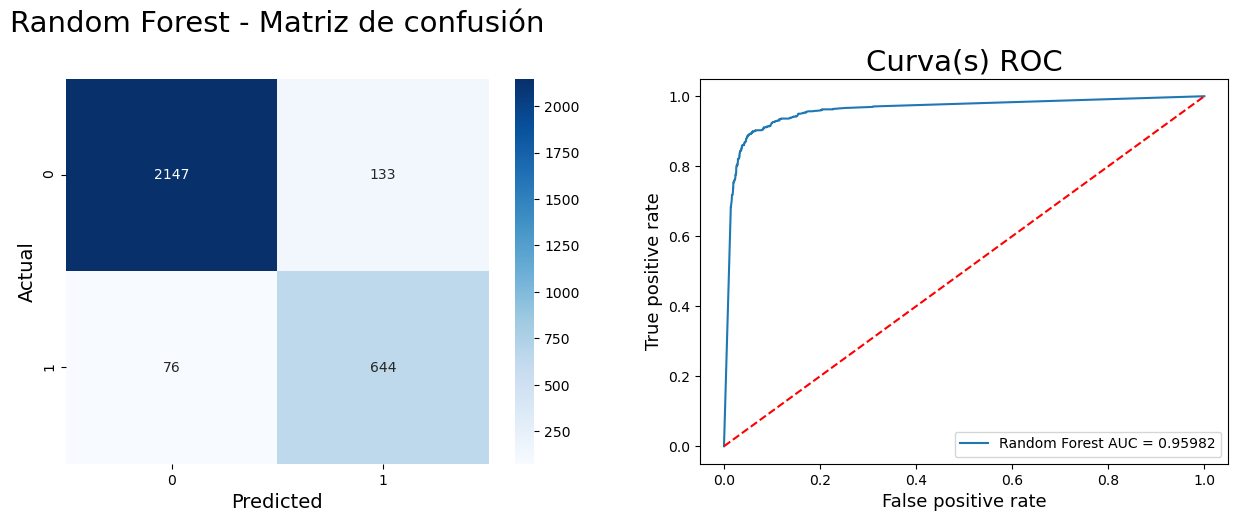

In [185]:
plot_roc_conf_matrix(y_test, X_test, clf, "Random Forest")
plt.show()

In [208]:
import joblib
# SE GUARDA EL MODELO
joblib.dump(clf, "model ex.pkl")

['model ex.pkl']

In [207]:
X_train.head(1)

,average_monthly_hours,satisfaction_level,salary_level_high,salary_level_low,salary_level_medium
0,247,0.84,0,1,0


# Clase 1: Pydantic

In [209]:
from pydantic import BaseModel as BM
from pydantic import Field
from typing import Literal

In [210]:
class InputModeloNo:
    def __init__(self, salary_level: str):
        if isinstance(salary_level, str):
            if salary_level in ["low", "medium", "high"]:
                self.salary_level = salary_level
                print(":)")
            else:
                print(":'(")
        else:
            print(":'(")

In [211]:
InputModeloNo(salary_level="low")

:)


In [212]:
class InputModelo(BM):
    """
    Clase que define las entradas del modelo según las verá el usuario.
    """

    average_monthly_hours: int = Field(
        ge=96, le=310, description="Horas promedio mensuales trabajadas"
    )
    satisfaction_level: float = Field(ge=0, le=1)
    salary_level: Literal["high", "low", "medium"]

    class Config:
        scheme_extra = {
            "example": {
                "average_monthly_hours": 201,
                "satisfaction_level": 0.42,
                "salay_level": "high",
            }
        }


class OutputModelo(BM):
    """
    Clase que define la salida del modelo según la verá el usuario.
    """

    employee_left: float = Field(ge=0, le=1)

    class Config:
        scheme_extra = {
            "example": {
                "employee_left": 0.69,
            }
        }

In [266]:
InputModelo(
    average_monthly_hours=average_monthly_hours,
    satisfaction_level=satisfaction_level,
    salary_level=salary_level,
)

InputModelo(average_monthly_hours=201, satisfaction_level=0.0, salary_level='low')

In [302]:
average_monthly_hours = 201
satisfaction_level = 0
salary_level = "high"

In [303]:
InputModelo(
    average_monthly_hours=average_monthly_hours,
    satisfaction_level=satisfaction_level,
    salary_level=salary_level,
)

salary_levels = [0] * 3

# Crea el DataFrame en el mismo orden las columnas del X_train

data_predict = pd.DataFrame(
    columns=[
        "average_monthly_hours",
        "satisfaction_level",
        "salary_level_high",
        "salary_level_low",
        "salary_level_medium",
    ],
    data=[[average_monthly_hours, satisfaction_level, *salary_levels]],
)

# Pone el 1 en la columna que debe ir el 1

data_predict[
    [
        x
        for x in data_predict.columns
        if ((salary_level in x) and (x.startswith("salary_level_")))
    ]
] = 1


pd.DataFrame(clf.predict_proba(data_predict)[:,1]).rename(
            columns={0: "prediccion"}
        )

,prediccion
0,0.79


In [273]:
pd.DataFrame(clf.predict_proba(data_predict)[:,1]).rename(
            columns={0: "prediccion"}
        )

,prediccion
0,0.79


# Clase 2: FastAPI

In [274]:
# Se carga el modelo

import joblib

first_model = joblib.load("model ex.pkl")

### Creamos un archivo llamado classes.py para guardar todo lo que hacemos con las clases

De la sesión pasada, tenmos parte del archivo:

In [313]:
from pydantic import BaseModel as BM
from pydantic import Field
from typing import Literal
import pandas as pd
import joblib


class InputModelo(BM):
    """
    Clase que define las entradas del modelo según las verá el usuario.
    """

    average_monthly_hours: int = Field(
        ge=96, le=310, description="Horas promedio mensuales trabajadas"
    )
    satisfaction_level: float = Field(ge=0, le=1)
    salary_level: Literal["high", "low", "medium"]

    class Config:
        scheme_extra = {
            "example": {
                "average_monthly_hours": 201,
                "satisfaction_level": 0.42,
                "salay_level": "high",
            }
        }


class OutputModelo(BM):
    """
    Clase que define la salida del modelo según la verá el usuario.
    """

    employee_left: float = Field(ge=0, le=1)

    class Config:
        scheme_extra = {
            "example": {
                "employee_left": 0.69,
            }
        }
        
        
class APIModelBackEnd:
    def __init__(self, average_monthly_hours, satisfaction_level, salary_level):

        self.average_monthly_hours = average_monthly_hours
        self.satisfaction_level = satisfaction_level
        self.salary_level = salary_level

    def cargar_modelo(self, nombre_modelo: str = "model ex.pkl"):
        self.model = joblib.load(nombre_modelo)

    def preparar_datos_modelo(self):

        average_monthly_hours = self.average_monthly_hours
        satisfaction_level = self.satisfaction_level
        salary_level = self.salary_level

        salary_levels = [0] * 3

        # Crea el DataFrame en el mismo orden las columnas del X_train

        data_predict = pd.DataFrame(
            columns=[
                "average_monthly_hours",
                "satisfaction_level",
                "salary_level_high",
                "salary_level_low",
                "salary_level_medium",
            ],
            data=[[average_monthly_hours, satisfaction_level, *salary_levels]],
        )

        # Pone el 1 en la columna que debe ir el 1

        data_predict[
            [
                x
                for x in data_predict.columns
                if ((salary_level in x) and (x.startswith("salary_level_")))
            ]
        ] = 1

        return data_predict

    def predecir(self):
        self.cargar_modelo()
        x = self.preparar_datos_modelo()
        prediccion = pd.DataFrame(self.model.predict_proba(x)[:,1]).rename(
            columns={0: "employee_left"}
        )     
        
        return prediccion.to_dict(orient="records")

In [335]:
first_class= APIModelBackEnd(average_monthly_hours=average_monthly_hours,
    satisfaction_level=satisfaction_level,
    salary_level=salary_level)
first_class.predecir()[0]

{'employee_left': 0.75}

In [317]:
from fastapi import FastAPI
from typing import List

app = FastAPI(title="Mi  API de ML", version='1.0.1')

@app.post("/predict", response_model= List[OutputModelo])
def predecir_probabilidad(inputs: List[InputModelo]):
    respuestas = list()
    for Input in inputs:
        first_model = APIModelBackEnd(Input.average_monthly_hours,
        Input.satisfaction_level,
        Input.salary_level)
        
        respuestas.append(first_model.predecir()[0])
        
    return respuestas
        



In [234]:
average_montly_hours = 201
satisfaction_level = 0
salary_level = "low"
test = APIModelBackEnd(
    average_montly_hours=average_montly_hours,
    satisfaction_level=satisfaction_level,
    salary_level=salary_level,
)

In [257]:
OutputModelo(employee_left=test.predecir()[0]["employee_left"])

OutputModelo(employee_left=0.75)

In [13]:
import requests

average_monthly_hours = 201
satisfaction_level = 0
salary_level = "low"

request_data = [{"average_monthly_hours": average_monthly_hours,
               "satisfaction_level": satisfaction_level,
               "salary_level":salary_level}]

data_cleaned = str(request_data).replace("'", '"')

url_api = "http://127.0.0.1:8000/predict"

pred = requests.post(url=url_api, data = data_cleaned).text

pred_df = pd.read_json(pred)

pred_df

,employee_left
0,0.75


# Clase 3

In [1]:
# leemos los datos de la fuente

df = pd.read_csv(
    "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/26/22,6/27/22,6/28/22,6/29/22,6/30/22,7/1/22,7/2/22,7/3/22,7/4/22,7/5/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,182149,182228,182324,182403,182528,182594,182643,182724,182793,182793
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,279077,279077,279167,280298,280851,281470,282141,282690,282690,282690
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,266038,266049,266062,266073,266087,266105,266115,266128,266173,266173
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,43774,43774,43774,43774,43774,44177,44177,44177,44177,44177
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,99761,99761,101320,101320,101320,101320,101320,101320,101320,101320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,658503,659853,659853,659853,659853,659853,659853,659853,662490,662490
281,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
282,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11824,11824,11824,11824,11824,11824,11824,11824,11832,11832
283,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,325110,325348,325498,325498,325857,325857,325857,326259,326259,326259


In [19]:
df_col = df[df['Country/Region'].apply(lambda x: x in ['Colombia'])].copy()
df_col

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/26/22,6/27/22,6/28/22,6/29/22,6/30/22,7/1/22,7/2/22,7/3/22,7/4/22,7/5/22
93,NaN,Colombia,4.5709,-74.2973,0,0,0,0,0,0,...,6151354,6151354,6151354,6151354,6175181,6175181,6175181,6175181,6175181,6175181


In [20]:
melted = df_col.melt(
    var_name="Fechas",
    value_name="confirmados",
    id_vars=["Province/State", "Country/Region", "Lat", "Long"],
)
melted

,Province/State,Country/Region,Lat,Long,Fechas,confirmados
0,NaN,Colombia,4.5709,-74.2973,1/22/20,0
1,NaN,Colombia,4.5709,-74.2973,1/23/20,0
2,NaN,Colombia,4.5709,-74.2973,1/24/20,0
3,NaN,Colombia,4.5709,-74.2973,1/25/20,0
4,NaN,Colombia,4.5709,-74.2973,1/26/20,0
...,...,...,...,...,...,...
891,NaN,Colombia,4.5709,-74.2973,7/1/22,6175181
892,NaN,Colombia,4.5709,-74.2973,7/2/22,6175181
893,NaN,Colombia,4.5709,-74.2973,7/3/22,6175181
894,NaN,Colombia,4.5709,-74.2973,7/4/22,6175181


In [21]:
import datetime

melted["Fechas"] = melted["Fechas"].apply(
    lambda x: datetime.datetime.strptime(x, "%m/%d/%y")
)

In [22]:
melted

,Province/State,Country/Region,Lat,Long,Fechas,confirmados
0,NaN,Colombia,4.5709,-74.2973,2020-01-22,0
1,NaN,Colombia,4.5709,-74.2973,2020-01-23,0
2,NaN,Colombia,4.5709,-74.2973,2020-01-24,0
3,NaN,Colombia,4.5709,-74.2973,2020-01-25,0
4,NaN,Colombia,4.5709,-74.2973,2020-01-26,0
...,...,...,...,...,...,...
891,NaN,Colombia,4.5709,-74.2973,2022-07-01,6175181
892,NaN,Colombia,4.5709,-74.2973,2022-07-02,6175181
893,NaN,Colombia,4.5709,-74.2973,2022-07-03,6175181
894,NaN,Colombia,4.5709,-74.2973,2022-07-04,6175181


In [6]:
import plotly.express as px

In [59]:
def dibujar_serie_tiempo(data, x = 'Fechas', y = "confirmados", title="Casos de COVID Confirmados en Colombia" )  :
    fig = px.line(
        data,
        x=x,
        y=y,
        title=title,
        color_discrete_sequence=["red", "blue"],
    )

    fig.update_layout(yaxis_title="Casos confirmados", xaxis_title="Fecha")
    # Esto elimina el color del fondo:
    fig.update_layout({"plot_bgcolor": "rgba(0,0,0,0)", "paper_bgcolor": "rgba(0,0,0,0)"})

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list(
                [
                    dict(step="day", stepmode="backward", label="1 semana", count=7),
                    dict(step="month", stepmode="backward", label="1 mes", count=1),
                    dict(step="month", stepmode="backward", label="3 meses", count=3),
                    dict(step="month", stepmode="backward", label="6 meses", count=6),
                    dict(label="Todos", step="all"),
                ]
            )
        ),
    )
    fig.update_traces(
        hovertemplate="<b><i>"
                      + "Casos confirmados"
                      + "</i></b>: %{y} <br><b><i>"
                      + "Fecha"
                      + "</i></b>: %{x} <extra></extra>"
    )
    return fig

# fig.update_xaxes(dtick='M1', ticklabelmode='period', tickformat="%d %b\n%Y")

fig = dibujar_serie_tiempo(melted)  
fig.show()

In [60]:
def plot_heatmap(df: pd.DataFrame, x: str, y: str):
    data_heatmap = (
        df.reset_index()[[x, y, "index"]]
            .groupby([x, y])
            .count()
            .reset_index()
            .pivot(x, y, "index")
            .fillna(0)
    )
    fig = px.imshow(
        data_heatmap,
        color_continuous_scale="Reds",
        aspect="auto",
        title=f"Heatmap {x} vs {y}",
    )
    fig.update_traces(
        hovertemplate="<b><i>"
                      + y
                      + "</i></b>: %{y} <br><b><i>"
                      + x
                      + "</i></b>: %{x} <br><b><i>Conteo interacción variables</i></b>: %{z}<extra></extra>"
    )
    return fig

In [51]:
df2 = pd.read_csv("datos.csv")
df2

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [54]:
plot_heatmap(df2, x='sales', y='salary')

ModuleNotFoundError: No module named 'uvicorn'

In [64]:
plotly.__version__

'5.3.0'